In [1]:
import os
import utm

import matplotlib.pyplot as plt
from xcube.core.store import new_data_store
import xarray as xr

xr.set_options(display_expand_attrs=False)

In [2]:
# greate s3 data store
file_store = new_data_store("file")

In [3]:
credentials = {
    "key": "O0M0CUQIDQO9TDZ4D8NR",
    "secret": "qPUyXs9G6j8on6MY5KPhQNHuA5uZTqxEscrbBCGx",
}

stac_store = new_data_store("stac-cdse", stack_mode=True, **credentials)


In [4]:
def create_utm_bounding_box(
    latitude: float, longitude: float, box_size_km: float = 10
) -> dict:
    # Convert WGS84 coordinates to UTM
    easting, northing, zone_number, zone_letter = utm.from_latlon(latitude, longitude)

    # Calculate half the size of the box in meters (5 km in each direction)
    # reduce the half size by half a pixel, because xcube evaluates the values at
    # the center of a pixel. Otherwise we get 1001x1001pixels instead of 1000x1000 pixel.
    box_size_m = box_size_km * 1000 - 10
    half_size_m = int(box_size_m / 2)

    # Calculate the coordinates of the bounding box corners, rounded to full meters
    easting_min = int(easting - half_size_m)
    northing_min = int(northing - half_size_m)
    easting_max = easting_min + box_size_m
    northing_max = northing_min + box_size_m

    # transform the bounds to lat lon
    point_west_south = utm.to_latlon(
        easting_min, northing_min, zone_number, zone_letter
    )
    point_east_north = utm.to_latlon(
        easting_max, northing_max, zone_number, zone_letter
    )
    bounding_box = {
        "center_utm": [float(northing), float(easting)],
        "center_wgs84": [latitude, longitude],
        "bbox_utm": [easting_min, northing_min, easting_max, northing_max],
        "bbox_wgs84": [
            float(point_west_south[1]),
            float(point_west_south[0]),
            float(point_east_north[1]),
            float(point_east_north[0]),
        ],
        "utm_zone": f"{zone_number}{zone_letter}",
    }
    return bounding_box

In [5]:
%%time
lat = 50.575537889829800
lon = 13.448324332077100
bbox = create_utm_bounding_box(
    lat, lon, box_size_km=10
)
ds = stac_store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox["bbox_utm"],
    crs=f"EPSG:326{bbox["utm_zone"][:2]}",
    spatial_res=10,
    time_range=["2016-11-01", "2016-11-30"],
    apply_scaling=True,
    angles_sentinel2=True,
    asset_names=[
        "B01",
        "B02",
        "B03",
        "B04",
        "B05",
        "B06",
        "B07",
        "B08",
        "B8A",
        "B09",
        "B11",
        "B12",
        "SCL",
    ],
)
ds

CPU times: user 16.7 s, sys: 895 ms, total: 17.6 s
Wall time: 1min 12s


<xarray.Dataset> Size: 294MB
Dimensions:        (time: 6, y: 1000, x: 1000, angle: 2, angle_y: 2,
                    angle_x: 2, band: 12)
Coordinates:
  * y              (y) float64 8kB 5.609e+06 5.609e+06 ... 5.599e+06 5.599e+06
  * x              (x) float64 8kB 3.851e+05 3.851e+05 ... 3.951e+05 3.951e+05
    spatial_ref    int64 8B 0
  * time           (time) datetime64[ns] 48B 2016-11-05T10:12:12.026000 ... 2...
  * angle          (angle) <U7 56B 'Zenith' 'Azimuth'
  * angle_y        (angle_y) float64 16B 5.604e+06 5.599e+06
  * angle_x        (angle_x) float64 16B 3.851e+05 3.901e+05
  * band           (band) <U5 240B 'B01' 'B02' 'B03' 'B04' ... 'B09' 'B11' 'B12'
Data variables: (12/15)
    B01            (time, y, x) float32 24MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    B09            (time, y, x) float32 24MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    B02            (time, y, x) float32 24MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    B03            (time, y, x) float32 24MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    B04            (time, y, x) float32 24MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    B08            (time, y, x) float32 24MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    ...             ...
    B8A            (time, y, x) float32 24MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    B11            (time, y, x) float32 24MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    B12            (time, y, x) float32 24MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    SCL            (time, y, x) uint8 6MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    solar_angle    (time, angle, angle_y, angle_x) float32 192B dask.array<chunksize=(1, 2, 2, 2), meta=np.ndarray>
    viewing_angle  (time, angle, band, angle_y, angle_x) float32 2kB dask.array<chunksize=(1, 2, 12, 2, 2), meta=np.ndarray>
Attributes: (2)

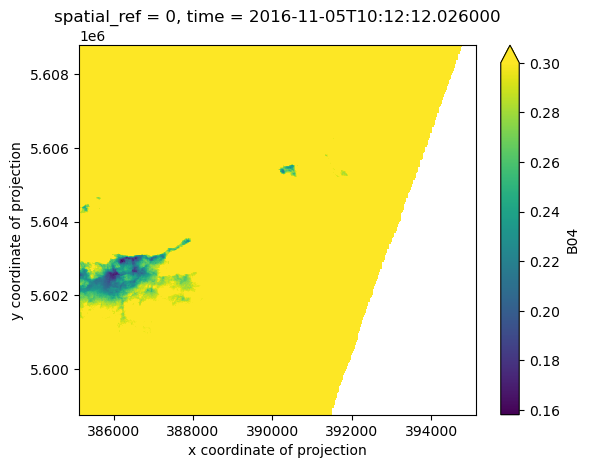

In [6]:
ds.B04.isel(time=0).plot(vmax=0.3)

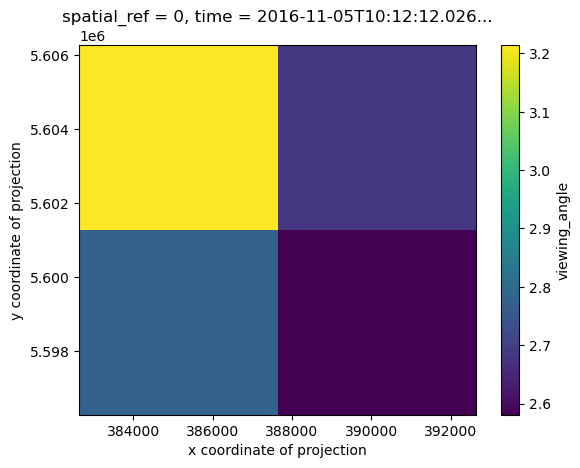

In [7]:
ds.viewing_angle.isel(time=0, band=3, angle=0).plot()